### CSCI-S-1O8 Final Project: Goodreads Book Recommender

#### By Anahata Raicar, Summer 2024

#### Table of Contents
1. [Overview](#Overview)
2. [Exploratory Data Analysis](#Exploratory_Data_Analysis)
3. [Modeling](#Modeling)
4. [Results](#Results)
5. [Future Work](#Future_Work)
6. [Conclusion](#Conclusion)

### <u>Overview </u> <a class="anchor" id="Overview"></a>

Ernest Hemingway once said, "There is no friend as loyal as a book”.  I am an avid reader and even in this digital era, I take immense pleasure in reading. One of the challenges readers always struggle with is discovering quality recommendations. Goodreads is my go-to source for finding new recommendations, but I’ve found myself with some bizarre and unexpected recommendations, which are not related to my reading or rating history, every now and then. There are reports from other users facing similar challenges.
<br>
<br>
Goodreads has its own recommendation engine which combines multiple proprietary algorithms, analyzing 20 billion data points to better predict which books people will want to read next. It maps out the connections between books by looking at how often they appear on the same bookshelves and whether they were enjoyed by the same people. However, these recommendations often fall short, representing a missed opportunity for Goodreads, which is owned by Amazon. Better recommendations would entice a user to buy those books on Amazon, thereby driving revenue.
<br>
<br>
Driven by sheer curiosity and the excitement to explore some of the techniques learnt in class, I'm going to develop a book recommendation system. I'm eager to assess its performance, the recommendations it proposes and learn about the challenges involved in build recommender systems.


We will now import the packages we need and load the data:

In [2]:
#import packages
import pandas as pd
import numpy as np
import plotly.express as px
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from surprise.prediction_algorithms.matrix_factorization import SVD, NMF
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms.knns import KNNBasic
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import Dataset, Reader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

### <u>Exploratory Data Analysis (EDA)</u> <a class="anchor" id="Exploratory_Data_Analysis"></a>

#### Data Source
While I originally planned on grabbing the data from https://mengtingwan.github.io/data/goodreads (recommended as a possible data source in class), I faced some memory issues and wasn’t able to download all of it. Therefore, I looked for an alternative data source and found a Github user who has collected and saved the data in his public repo - https://github.com/zygmuntz/goodbooks-10k/tree/master . 


We will now explore the data and try to identify inherent patterns and relationships:

In [3]:
#load data
#books
df_books = pd.read_csv("/Users/Anahata/Desktop/Harvard/Data Mining/Project/data/books.csv")
df_books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [4]:
#explore df
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [5]:
#bring in ratings data
df_ratings = pd.read_csv("/Users/Anahata/Desktop/Harvard/Data Mining/Project/data/ratings.csv")
df_ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [6]:
#explore df
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


In [7]:
#no. of unique books 
print("The number of unique users in the dataset is", df_books.book_id.nunique())

The number of unique users in the dataset is 10000


In [8]:
unique_users = df_ratings['user_id'].nunique()
print("The number of unique users in the dataset is", unique_users)

The number of unique users in the dataset is 53424


<b>As we can see above, the dataset contains 10,000 unique users and 53,424 ratings.</b>
</br>
</br>
We will now merge the columns we need from both datasets into a combined dataframe.

In [9]:
#grab the columns we need from both dfs and merge 

df = pd.merge(df_books[['book_id', 'isbn', 'authors', 'original_publication_year', 'language_code','original_title', 'title', 'ratings_count' , 'average_rating']],
              df_ratings, on='book_id')
df.head()

,book_id,isbn,authors,original_publication_year,language_code,original_title,title,ratings_count,average_rating,user_id,rating
0,1,439023483,Suzanne Collins,2008.0,eng,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",4780653,4.34,2886,5
1,1,439023483,Suzanne Collins,2008.0,eng,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",4780653,4.34,6158,5
2,1,439023483,Suzanne Collins,2008.0,eng,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",4780653,4.34,3991,4
3,1,439023483,Suzanne Collins,2008.0,eng,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",4780653,4.34,5281,5
4,1,439023483,Suzanne Collins,2008.0,eng,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",4780653,4.34,5721,5


We will now check the number of missing values in each column:

In [10]:
#missing values
missing_percent = df.isnull().mean() * 100

print("Percentage of missing values in each column:")
print(missing_percent.apply(lambda x: '{:.2f}%'.format(x)))

Percentage of missing values in each column:
book_id                      0.00%
isbn                         3.56%
authors                      0.00%
original_publication_year    0.10%
language_code                5.64%
original_title               2.69%
title                        0.00%
ratings_count                0.00%
average_rating               0.00%
user_id                      0.00%
rating                       0.00%
dtype: object


As we can see above, isbn, language_code, original_title have some missing values. However, it will not impact  our modeling process as these variables have been chosen for data exploration only.

We will now analyze the relationships between the variables of this dataset:

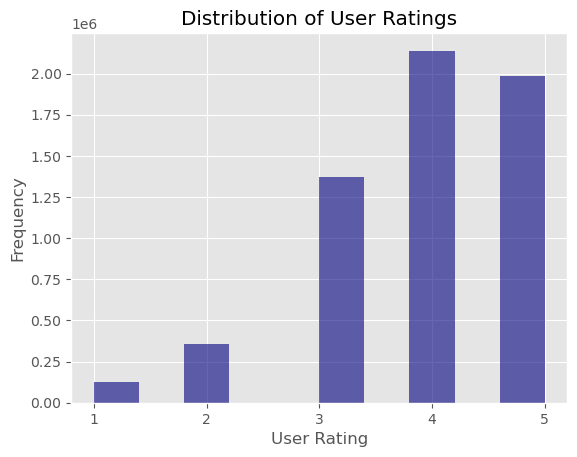

In [11]:
#lets look at how users rate books and what is the most frequent rating

plt.hist(df.rating, alpha = 0.6, color='navy')
plt.xticks(range(1, 6))
plt.xlabel('User Rating')
plt.ylabel('Frequency')
plt.title('Distribution of User Ratings')
plt.show()

<b>Based on all the ratings given by the universe of users, we can see that most of them give a rating of 4 or 5. </b>

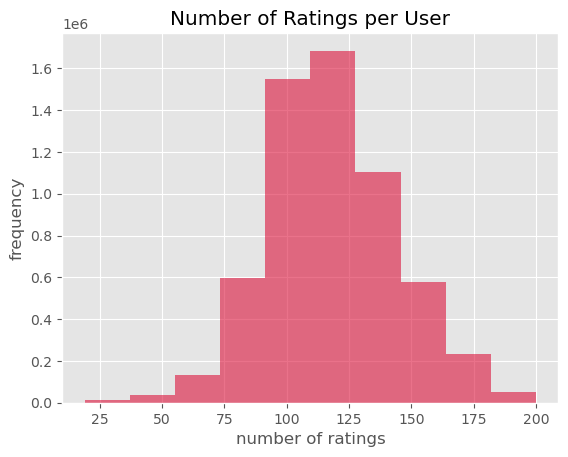

In [12]:
#no of ratings per user 

eda = df
eda['number_of_ratings_user'] = eda['user_id'].groupby(eda['user_id']).transform('count')
plt.hist(eda.number_of_ratings_user, alpha = 0.6, color = 'crimson')
plt.xlabel('number of ratings')
plt.ylabel('frequency')
plt.title('Number of Ratings per User')
plt.show()

In [13]:
#average number of ratings per user
eda2 = eda[['user_id', 'number_of_ratings_user']].copy()
eda2.drop_duplicates(inplace=True)

print(eda2.number_of_ratings_user.mean())


111.86880428271938


<b>From the distribution above, we can see that most of the users rate 75-150 books. The average number of books rated by a user is 112. </b>

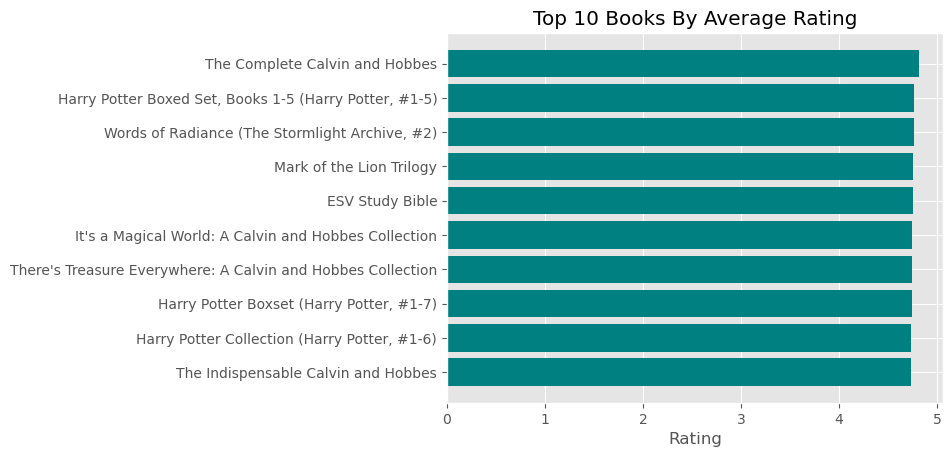

In [14]:
#top 10 rated books

df_sorted = df_books.sort_values(by='average_rating', ascending=False)
top_10_values = df_sorted.head(10)

plt.barh(top_10_values['title'], top_10_values['average_rating'], color='teal')
plt.xlabel('Rating')
plt.title('Top 10 Books By Average Rating')
plt.gca().invert_yaxis()
plt.show()

<b>“The Complete Calvin and Hobbes” is the best book based on the average rating.</b>

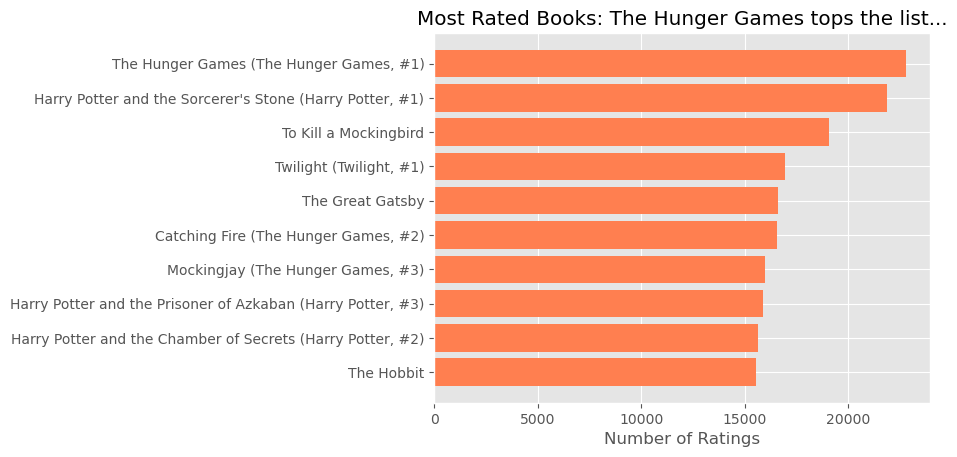

In [15]:
# Show the ratings count for the 10 most popular books
df['rating_count'] = df['book_id'].groupby(df['book_id']).transform('count')
popular = df.sort_values('rating_count', ascending=False)

# drop duplicate books
popular = popular.drop_duplicates(subset='book_id', keep="first")
popular = popular[['book_id', 'title', 'rating_count']].head(10)

plt.barh(popular['title'], popular['rating_count'], color='coral')
plt.xlabel('Number of Ratings')
plt.title('Most Rated Books: The Hunger Games tops the list...')
plt.gca().invert_yaxis()
plt.show()

<b> “The Hunger Games” is the most rated book, it was 22.8K times.</b>

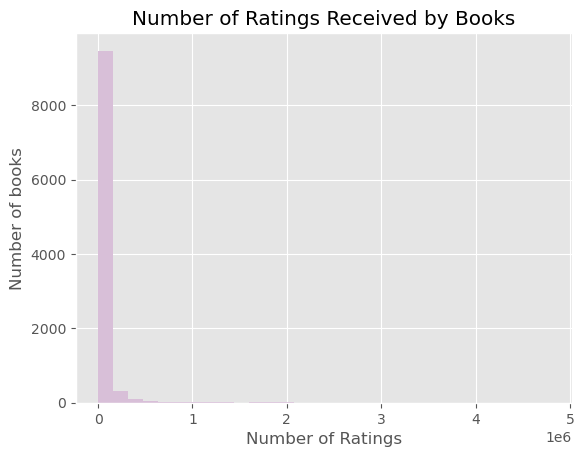

In [16]:
#distribution of ratings count vs books count
books_ratings = df[['book_id', 'title', 'ratings_count']].copy()
books_ratings.drop_duplicates(inplace=True)


plt.hist(books_ratings['ratings_count'], bins=30, color='thistle')
plt.title('Number of Ratings Received by Books')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of books')
plt.show()

In [17]:
#how many books got more than 5k ratings?
books_50k = books_ratings[books_ratings['ratings_count'] > 50000]

books_50k_cnt = books_50k.shape[0]

print(f" The number of books with more than 50,000 ratings is {books_50k_cnt}")

 The number of books with more than 50,000 ratings is 2003


In [18]:
#how many books got more than 10k ratings?
books_1mm = books_ratings[books_ratings['ratings_count'] > 1000000]

books_1mm_cnt = books_1mm.shape[0]

print(f" The number of books with more than 1MM ratings is {books_1mm_cnt}")

 The number of books with more than 1MM ratings is 54


<b> From the histogram above, we can see that out of the 10k books, majority of the books received less than 50k ratings. 2003 books received more than 50k ratings and only 54 books received more than 1MM ratings. </b>

In [19]:
#how many books does a user rate on average

user_rating_cnt = df_ratings.groupby('user_id')['rating'].count().reset_index()
user_rating_cnt.rename({'rating':'rating_cnt'}, axis=1, inplace=True)

print(" The average number of books rated by a user is:", round(user_rating_cnt.rating_cnt.mean(),2))

 The average number of books rated by a user is: 111.87


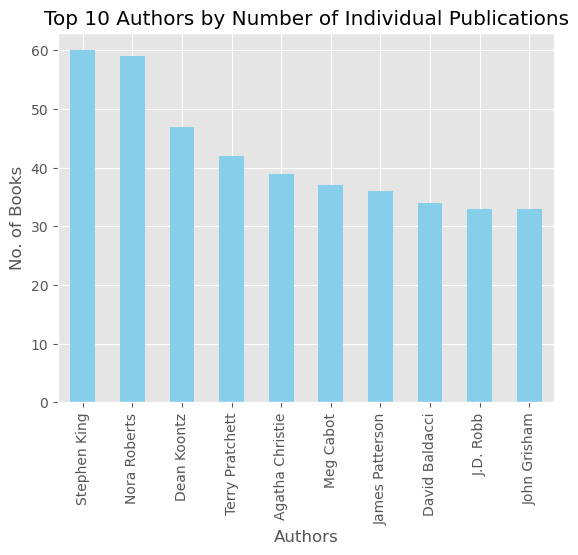

In [20]:
# lets take a look at the most frequent authors

df_books.authors.value_counts()[:10].plot(kind="bar",  color='skyblue')
plt.xlabel('Authors')
plt.ylabel('No. of Books')
plt.title('Top 10 Authors by Number of Individual Publications')
plt.show()


<b>Out of the 10k books in the dataset, Stephen King has authored the most books – 61 individual books and he co-authored an additional 36 books. </b>

In [21]:
#no of unique authors

unique_authors = df_books.authors.nunique()
print("The number of unique authors in the dataset is", unique_authors)

The number of unique authors in the dataset is 4664


In [22]:
df_books['language_code'].value_counts()

language_code
eng      6341
en-US    2070
en-GB     257
ara        64
en-CA      58
fre        25
ind        21
spa        20
ger        13
per         7
jpn         7
por         6
pol         6
en          4
nor         3
dan         3
fil         2
ita         2
vie         1
tur         1
nl          1
swe         1
rum         1
mul         1
rus         1
Name: count, dtype: int64

In [23]:
# no. of english books
eng_codes = ['eng', 'en-US', 'en-GB', 'en-CA']

eng_df = df_books[df_books['language_code'].isin(eng_codes)]
print("The number of English books in the datset is", eng_df.goodreads_book_id.count())

The number of English books in the datset is 8726


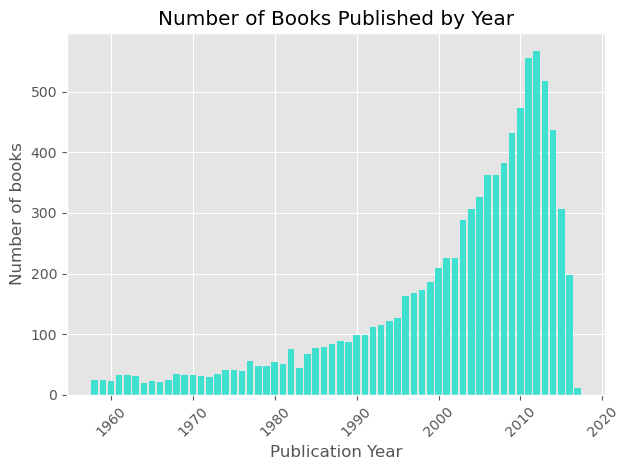

In [24]:
#when were the books published
books_years = df_books.groupby(['original_publication_year'])['title'].count().tail(60)
plt.bar(books_years.index, books_years.values, color='turquoise')

plt.xticks(rotation=45)
plt.xlabel('Publication Year')
plt.ylabel('Number of books')
plt.title('Number of Books Published by Year')

plt.tight_layout()
plt.show()

<b>Distribution of books by publication year – majority of books in the dataset were published post 2000. </b>

Now let's examine the relationship between the number of ratings given to a book and its average rating:

In [25]:
#relationship between number of ratings and avg rating 

#number of ratings by book id 

ratings_cnt_book = df_ratings.groupby('book_id')['rating'].count().reset_index()
ratings_cnt_book.rename({'rating':'ratings_count'}, axis=1, inplace=True)
ratings_cnt_book.head()

,book_id,ratings_count
0,1,22806
1,2,21850
2,3,16931
3,4,19088
4,5,16604


In [26]:
#merge 
rating_cnt_avg = pd.merge(df_books[['book_id', 'average_rating']], ratings_cnt_book, on='book_id')
rating_cnt_avg.head()

,book_id,average_rating,ratings_count
0,1,4.34,22806
1,2,4.44,21850
2,3,3.57,16931
3,4,4.25,19088
4,5,3.89,16604


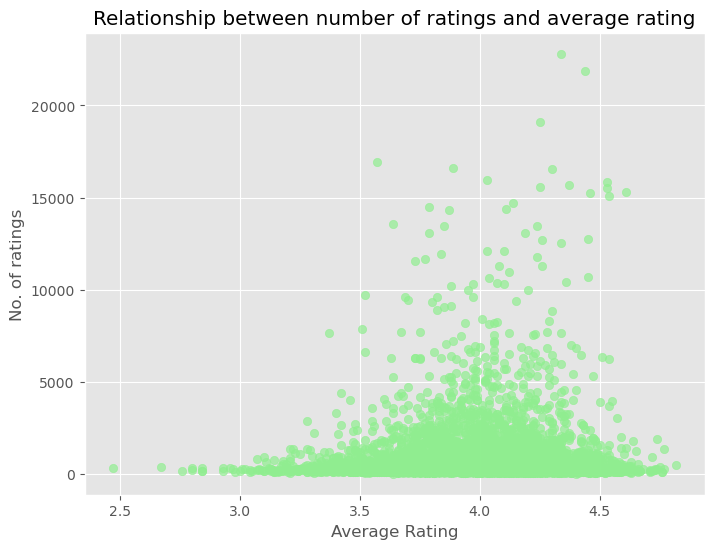

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(rating_cnt_avg['average_rating'], rating_cnt_avg['ratings_count'], color='lightgreen', alpha=0.7)
plt.title('Relationship between number of ratings and average rating')
plt.ylabel('No. of ratings')
plt.xlabel('Average Rating')
plt.grid(True)
plt.show()

<b>The scatter plot below shows the relationship between the average rating and the number of ratings a book received. We can observe that as the number of ratings given to a book goes up, the average rating gets closer to 4. </b>

We will now delete the isbn, original title and language code as we won't be utilizing them for building the recommender system.

In [28]:
df.drop(['isbn', 'original_title'], axis=1, inplace=True)

In [29]:
#also drop cols created
df.drop(['number_of_ratings_user', 'rating_count'], axis=1, inplace=True)

In [30]:
df.head()

,book_id,authors,original_publication_year,language_code,title,ratings_count,average_rating,user_id,rating
0,1,Suzanne Collins,2008.0,eng,"The Hunger Games (The Hunger Games, #1)",4780653,4.34,2886,5
1,1,Suzanne Collins,2008.0,eng,"The Hunger Games (The Hunger Games, #1)",4780653,4.34,6158,5
2,1,Suzanne Collins,2008.0,eng,"The Hunger Games (The Hunger Games, #1)",4780653,4.34,3991,4
3,1,Suzanne Collins,2008.0,eng,"The Hunger Games (The Hunger Games, #1)",4780653,4.34,5281,5
4,1,Suzanne Collins,2008.0,eng,"The Hunger Games (The Hunger Games, #1)",4780653,4.34,5721,5


Results of this initial data exploration suggest that the data is well-structured and of great quality. We can now begin building our recommender system.

### <u>Modeling </u> <a class="anchor" id="Modeling"></a>

<b>Baseline Model: </b>

To deal with the cold start problem, we will build a baseline model which will recommend books with the highest ratings to all users,  ignoring their individual reading or rating history. Recommendations from this model will be given to new users who have no history with the platform. 

One of the challenges with this approach is that user ratings alone to rank and recommend books can be misleading, as it doesn’t account for the number of readers who rated them, which can skew perceptions of quality. For example, a book with a high rating from a few readers might seem better than a book with a slightly lower rating from many readers. This method might favor books with few but very high ratings when infact a higher number of readers tend to provide a more reliable indication of quality. To overcome this, we will set a threshold of 1MM for the number of ratings a book must have and then recommend the top 10 with the highest average rating. From the distribution we plotted earlier, we saw that only 54 books received more than 1MM ratings so they must be books which readers really enjoy reading.

In [31]:
#build a baseline model for cold start
baseline_df = df[['book_id', 'authors', 'original_publication_year', 'title', 'ratings_count', 'average_rating']].copy()
baseline_df.drop_duplicates(inplace=True)
baseline_df = baseline_df[(baseline_df['ratings_count'] > 1000000)]

top10 = baseline_df.sort_values(by='average_rating', ascending=False).reset_index()
top10_books = top10[['book_id', 'title', 'authors', 'ratings_count', 'average_rating']].head(10)
top10_books

,book_id,title,authors,ratings_count,average_rating
0,25,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré",1746574,4.61
1,27,Harry Potter and the Half-Blood Prince (Harry ...,"J.K. Rowling, Mary GrandPré",1678823,4.54
2,18,Harry Potter and the Prisoner of Azkaban (Harr...,"J.K. Rowling, Mary GrandPré, Rufus Beck",1832823,4.53
3,24,Harry Potter and the Goblet of Fire (Harry Pot...,"J.K. Rowling, Mary GrandPré",1753043,4.53
4,21,Harry Potter and the Order of the Phoenix (Har...,"J.K. Rowling, Mary GrandPré",1735368,4.46
5,39,"A Game of Thrones (A Song of Ice and Fire, #1)",George R.R. Martin,1319204,4.45
6,31,The Help,Kathryn Stockett,1531753,4.45
7,2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",4602479,4.44
8,23,Harry Potter and the Chamber of Secrets (Harry...,"J.K. Rowling, Mary GrandPré",1779331,4.37
9,47,The Book Thief,Markus Zusak,1159741,4.36


These are the top 10 books with the highest average rating which we could recommend to all new readers. However, majority of the books are part of the Harry Potter series. While these books might genuinely be the most loved, these results could also indicate the presence of some bias - Harry Potter  readers tend to rate books more than other readers. Furthermore, not every new reader might enjoy reading them and it would be ideal to recommend a range of authors for them to choose from. To overcome this, we will limit the number of books from each author in the top 10 to 1 and also lower the threshold for the number of ratings from 1MM to 500K.

In [32]:
# we will limit the number of authors to 1
baseline_df2 = df[['book_id', 'authors', 'original_publication_year', 'title', 'ratings_count', 'average_rating']].copy()
baseline_df2.drop_duplicates(inplace=True)
baseline_df2 = baseline_df[(baseline_df['ratings_count'] > 500000)]

baseline_df2 = baseline_df2.sort_values(by='average_rating', ascending=False).reset_index()

#keep track of authors, we will check how many times the authors have appeared 
books_to_recommend = []
author_count = {}

for idx, row in baseline_df2.iterrows():
    authors = [author.strip() for author in row['authors'].split(',')]
    if all(author_count.get(author, 0) < 1 for author in authors):
        books_to_recommend.append(row)
        for author in authors:
            author_count[author] = author_count.get(author, 0) + 1
    if len(books_to_recommend) >= 10:
        break

books_to_recommend_df = pd.DataFrame(books_to_recommend)

books_to_recommend_df[['book_id','title', 'authors', 'ratings_count', 'average_rating']]

,book_id,title,authors,ratings_count,average_rating
0,25,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré",1746574,4.61
5,39,"A Game of Thrones (A Song of Ice and Fire, #1)",George R.R. Martin,1319204,4.45
6,31,The Help,Kathryn Stockett,1531753,4.45
9,47,The Book Thief,Markus Zusak,1159741,4.36
10,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4780653,4.34
11,19,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. Tolkien,1766803,4.34
13,50,Where the Sidewalk Ends,Shel Silverstein,1016888,4.29
14,11,The Kite Runner,Khaled Hosseini,1813044,4.26
15,6,The Fault in Our Stars,John Green,2346404,4.26
16,4,To Kill a Mockingbird,Harper Lee,3198671,4.25


This is a much better list and it includes books written by a range of authors, these books will be recommended to new readers who do not have any reading or rating history. As an avId reader myself, I can vouch for the quality of the books on this list and their merit as recommendations.

<b>Leveraging the Surprise library for modeling: </b>
<br>
<br>
We wll now experiment with the Surprise package we used in class.Surprise is an open-source Python library specifically designed for recommendation tasks, making it easier to develop and evaluate recommender systems. We will experiment with Baseline, SVD and KNNBasic models which we also explored in class to build a book recommender system.
<br>
<b>Baseline:</b> Provides predictions based on a baseline estimation method.
<br>
<b>KNNBasic:</b>  Finds neighbors (similar users/items) and predicts ratings based on those neighbors.
<br>
<b>SVD:</b> Decomposes the user-item matrix into latent factors and uses them to predict ratings.


We will first run the BaselineOnly() model:

In [33]:
#in the surprise library, the reader class is used to parse the dataset
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df[['user_id', 'book_id', 'rating']], reader)

In [34]:
#split data into train and test
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.20)

We will create a function to calculate the predictions and evaluate the model based on RMSE and MAE and save the model results in a dataframe.

In [35]:
results_df = pd.DataFrame(columns=['Model', 'RMSE', 'MAE'])

# function to train and evaluate model
def evaluate_model(model_name, model,trainset, testset):

    model.fit(trainset)
    
    predictions = model.test(testset)
    
    rmse = accuracy.rmse(predictions, verbose=False)
    mae = accuracy.mae(predictions, verbose=False)
    
    #append results to results_df
    results_df.loc[len(results_df)] = [model_name, rmse, mae]
    return predictions


We will also create a function to generate recommendations based on the BaselineOnly model. The function will  generate recommendations for a specific user based on their user_id.

In [36]:
def generate_top10_recommendations(predictions, user_id, n=10):

    # get predictions for user and then sort on rating and return the top10
    user_predicted_ratings = [(iid, est) for uid, iid, true_r, est,_ in predictions if uid == user_id]
    user_predicted_ratings.sort(key=lambda x: x[1], reverse=True)

    top_10_recommendations = user_predicted_ratings[:n]
    
    return pd.DataFrame(top_10_recommendations, columns=['book_id', 'estimated_rating'])


In [37]:
predictions = evaluate_model("Baseline", BaselineOnly(), trainset, testset)

Estimating biases using als...


In [38]:
results_df

,Model,RMSE,MAE
0,Baseline,0.854184,0.670973


In [39]:
#generate recommendations for a user 
user_id = 3991
top_10_recommendations = generate_top10_recommendations(predictions, user_id, n=10)

print(f"Top-10 recommendations for user {user_id}:")
print(top_10_recommendations)

Top-10 recommendations for user 3991:
   book_id  estimated_rating
0       27          4.632943
1     1223          4.491084
2        1          4.428017
3      159          4.303598
4     9079          4.278896
5     5070          4.268755
6       93          4.252255
7      231          4.248356
8     4581          4.190433
9     2850          4.177656


We will now display the recommendations for user 3991:

In [40]:
recommendations = pd.merge(top_10_recommendations, df_books[['book_id', 'authors', 'title']], on='book_id')
recommendations

,book_id,estimated_rating,authors,title
0,27,4.632943,"J.K. Rowling, Mary GrandPré",Harry Potter and the Half-Blood Prince (Harry ...
1,1223,4.491084,Isaac Asimov,"The Foundation Trilogy (Foundation, #1-3)"
2,1,4.428017,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)"
3,159,4.303598,Rick Riordan,The Battle of the Labyrinth (Percy Jackson and...
4,9079,4.278896,Gerald N. Lund,"Like a Fire Burning (The Work and the Glory, #2)"
5,5070,4.268755,"T. Colin Campbell, Thomas M. Campbell II",The China Study: The Most Comprehensive Study ...
6,93,4.252255,Frances Hodgson Burnett,The Secret Garden
7,231,4.248356,Tatiana de Rosnay,Sarah's Key
8,4581,4.190433,Melina Marchetta,"Finnikin of the Rock (Lumatere Chronicles, #1)"
9,2850,4.177656,Maria V. Snyder,"Magic Study (Study, #2)"


<b>Given the simplicity of this model, the RMSE and MAE are pretty impressive.</b>

We will now try running the SVD model:

In [41]:
#run SVD model
predictions_svd = evaluate_model("SVD",  SVD(), trainset, testset)
results_df

,Model,RMSE,MAE
0,Baseline,0.854184,0.670973
1,SVD,0.829717,0.640677


In [42]:
#generate recommendations for a user 
user_id = 3991
top_10_recommendations_svd = generate_top10_recommendations(predictions_svd, user_id, n=10)

print(f"Top-10 recommendations from the SVD model for user {user_id}:")
print(top_10_recommendations_svd)

Top-10 recommendations from the SVD model for user 3991:
   book_id  estimated_rating
0       27          4.809251
1        1          4.564461
2     1223          4.561599
3     9079          4.517010
4     5070          4.508599
5       42          4.442137
6      231          4.428630
7       93          4.288021
8     2850          4.229381
9     6503          4.228579


In [43]:
recommendations_svd = pd.merge(top_10_recommendations_svd, df_books[['book_id', 'authors', 'title']], on='book_id')
recommendations_svd

,book_id,estimated_rating,authors,title
0,27,4.809251,"J.K. Rowling, Mary GrandPré",Harry Potter and the Half-Blood Prince (Harry ...
1,1,4.564461,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)"
2,1223,4.561599,Isaac Asimov,"The Foundation Trilogy (Foundation, #1-3)"
3,9079,4.517010,Gerald N. Lund,"Like a Fire Burning (The Work and the Glory, #2)"
4,5070,4.508599,"T. Colin Campbell, Thomas M. Campbell II",The China Study: The Most Comprehensive Study ...
5,42,4.442137,Louisa May Alcott,"Little Women (Little Women, #1)"
6,231,4.428630,Tatiana de Rosnay,Sarah's Key
7,93,4.288021,Frances Hodgson Burnett,The Secret Garden
8,2850,4.229381,Maria V. Snyder,"Magic Study (Study, #2)"
9,6503,4.228579,Jaclyn Moriarty,The Year of Secret Assignments (Ashbury/Brookf...


<b>We can see that the SVD model performs better than the BaselineOnly model, the RMSE and MAE are both lower for the SVD model. SVD models generally tend to perform better when sparsity is not an issue. In terms of the recommendations generated,  we do see some overlap.</b>

We also tried to run the KNNBasic model but due to memory issues, the process had to be aborted.

In [ ]:
# predictions_knn = evaluate_model("KNNBasic",  KNNBasic(), trainset, testset)
# results_df

<br> 
<b> Collaborative Filtering </b>

Collaborative Filtering recommends items based on similarity measures between users and/or items. The basic assumption behind the algorithm is that users with similar interests have common preferences. We will build a collaborative filtering recommender model from scratch, taking into account the ratings readers have given to authors. We will calculate the similarity between authors and recommend books written by authors who have the highest estimated rating.

In [44]:
#due to memory constraints, we will only work with books who got atleast 50k ratings. Tried running it with the entire dataset but it failed.
books_ratings = df[['book_id', 'title', 'authors', 'ratings_count']].copy()
books_50k = books_ratings[books_ratings['ratings_count'] >= 50000]

In [ ]:
books_50k.drop_duplicates(inplace=True)
#books_50k.info()

In [46]:
#get the users and the ratings
df_cf = df[['user_id', 'book_id', 'authors', 'rating', 'language_code']].copy()

In [47]:
#merge books with ratings
df_cf2 = pd.merge(df_cf, books_50k['book_id'], on='book_id', how='inner')
df_cf2.head()

,user_id,book_id,authors,rating,language_code
0,2886,1,Suzanne Collins,5,eng
1,6158,1,Suzanne Collins,5,eng
2,3991,1,Suzanne Collins,4,eng
3,5281,1,Suzanne Collins,5,eng
4,5721,1,Suzanne Collins,5,eng


In [48]:
#we will filter keep the English books only and filter out other languages
languages = ['eng', 'en-US', 'en-GB', 'en-CA']
df_cf2 = df_cf2[df_cf2['language_code'].isin(languages)] 

In [49]:
df_cf2.drop(['book_id', 'language_code'], axis=1, inplace=True)

In [50]:
#drop duplicate rows because a user might have rated a book by the same author multiple times
df_cf2.drop_duplicates(inplace=True)

In [51]:
#a book could have multiple authors, we will create a list of the authors
df_cf2['authors'] = df_cf2['authors'].str.split(',')
df_cf2.head()

,user_id,authors,rating
0,2886,[Suzanne Collins],5
1,6158,[Suzanne Collins],5
2,3991,[Suzanne Collins],4
3,5281,[Suzanne Collins],5
4,5721,[Suzanne Collins],5


Now that we have processed and transformed the data, we can begin building the collaborative filtering model. We will split the data into a train and test set. This step is important to assess how well the recommender system generalizes to unseen data.

In [52]:
#we will split our data into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_cf2, test_size=0.2, random_state=42)

In [53]:
#since a book could have multiple authors, we need to explode them into seperate rows

train_df= train.explode('authors')
test_df = test.explode('authors')

In [54]:
train_df.head()

,user_id,authors,rating
328278,33683,Alice Sebold,5
701069,26699,Sue Monk Kidd,3
31831,27627,J.K. Rowling,3
31831,27627,Mary GrandPré,3
2066938,31525,Jack London,4


The next step is creating a user-item matrix, in this case, the items are the authors.

In [55]:
# we will now have to create user-author (user-item) matrices for both the train and test set

user_author_train_matrix = train_df.groupby(['user_id', 'authors'])['rating'].mean().unstack().fillna(0)
user_author_test_matrix = test_df.groupby(['user_id', 'authors'])['rating'].mean().unstack().fillna(0)

In [56]:
user_author_train_matrix.head()

authors   A.W. Wheen   Abraham Verghese   Adam McCauley   Adolph Caso  \
user_id                                                                 
1                0.0                0.0             0.0           0.0   
2                0.0                0.0             0.0           0.0   
3                0.0                0.0             0.0           0.0   
4                0.0                0.0             0.0           0.0   
5                0.0                5.0             0.0           0.0   

authors   Adrian Alphona   Akira Watanabe   Alan Daniel   Alan Myers  \
user_id                                                                
1                    0.0              0.0           0.0          0.0   
2                    0.0              0.0           0.0          0.0   
3                    0.0              0.0           0.0          0.0   
4                    0.0              0.0           0.0          0.0   
5                    0.0              0.0           0.0          0.0   

authors   Alan R. Clarke   Alan Shelston   Albus Dumbledore   Alethea Nibley  \
user_id                                                                        
1                    5.0             0.0                0.0              0.0   
2                    0.0             0.0                0.0              0.0   
3                    0.0             0.0                0.0              0.0   
4                    5.0             0.0                0.0              0.0   
5                    0.0             0.0                0.0              0.0   

authors   Alev Lytle Croutier   Alex Haley   Alex Prud'Homme  \
user_id                                                        
1                         0.0          0.0               0.0   
2                         0.0          0.0               0.0   
3                         0.0          3.0               0.0   
4                         0.0          0.0               0.0   
5                         0.0          0.0               0.0   

authors   Alexander Teixeira de Mattos   Alfred Birnbaum   Alfred MacAdam  \
user_id                                                                     
1                                  0.0               0.0              0.0   
2                                  0.0               0.0              0.0   
3                                  0.0               0.0              0.0   
4                                  0.0               0.0              0.0   
5                                  0.0               0.0              5.0   

authors   Alison Anderson   Alison Leslie Gold   Allen Mandelbaum  \
user_id                                                             
1                     4.0                  0.0                0.0   
2                     0.0                  0.0                0.0   
3                     0.0                  0.0                0.0   
4                     0.0                  0.0                0.0   
5                     0.0                  0.0                0.0   

authors   Allison Silverman   Andrew Delbanco   Andrew Gross  \
user_id                                                        
1                       0.0               0.0            0.0   
2                       0.0               0.0            0.0   
3                       0.0               0.0            0.0   
4                       0.0               0.0            0.0   
5                       0.0               0.0            0.0   

authors   Andrew R. MacAndrew   Andy Nakatani   Angelo  Rinaldi   Anita Jeram  \
user_id                                                                         
1                         0.0             0.0               0.0           0.0   
2                         0.0             0.0               0.0           0.0   
3                         0.0             0.0               0.0           0.0   
4                         0.0             0.0               0.0           0.0   
5             

Now that we created the user-author matrix, we will use cosine similarity to calculate the similarity between authors based on user interactions with them. Cosine similarity measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction.

In [57]:
#function to assess cosine similairty between the authors
def assess_similarity(user_author_matrix):
    author_similarity = cosine_similarity(user_author_matrix.T)
    df_author_similarity = pd.DataFrame(author_similarity, index=user_author_matrix.columns, columns=user_author_matrix.columns)
    return df_author_similarity


In [58]:
# estimate author similarities
df_train_author_similarity = assess_similarity(user_author_train_matrix)


In [59]:
df_train_author_similarity.head()

authors             A.W. Wheen   Abraham Verghese   Adam McCauley  \
authors                                                             
 A.W. Wheen           1.000000           0.018504        0.025478   
 Abraham Verghese     0.018504           1.000000        0.003116   
 Adam McCauley        0.025478           0.003116        1.000000   
 Adolph Caso          0.112101           0.012394        0.025687   
 Adrian Alphona       0.008762           0.005797        0.010503   

authors             Adolph Caso   Adrian Alphona   Akira Watanabe  \
authors                                                             
 A.W. Wheen            0.112101         0.008762         0.011640   
 Abraham Verghese      0.012394         0.005797         0.000000   
 Adam McCauley         0.025687         0.010503         0.023218   
 Adolph Caso           1.000000         0.006418         0.017848   
 Adrian Alphona        0.006418         1.000000         0.007222   

authors             Alan Daniel   Alan Myers   Alan R. Clarke   Alan Shelston  \
authors                                                                         
 A.W. Wheen            0.023353     0.078251         0.094724        0.038928   
 Abraham Verghese      0.002495     0.009510         0.049585        0.007580   
 Adam McCauley         0.178775     0.007436         0.027654        0.012001   
 Adolph Caso           0.012312     0.088190         0.091498        0.025773   
 Adrian Alphona        0.005219     0.005269         0.006436        0.000000   

authors             Albus Dumbledore   Alethea Nibley   Alev Lytle Croutier  \
authors                                                                       
 A.W. Wheen                 0.026397         0.009593              0.050995   
 Abraham Verghese           0.009568         0.000830              0.004104   
 Adam McCauley              0.043091         0.034929              0.019908   
 Adolph Caso                0.028799         0.019398              0.059744   
 Adrian Alphona             0.022205         0.003194              0.001272   

authors             Alex Haley   Alex Prud'Homme  \
authors                                            
 A.W. Wheen           0.078099          0.025679   
 Abraham Verghese     0.013971          0.026718   
 Adam McCauley        0.009414          0.007599   
 Adolph Caso          0.073711          0.011252   
 Adrian Alphona       0.000000          0.003272   

authors             Alexander Teixeira de Mattos   Alfred Birnbaum  \
authors                                                              
 A.W. Wheen                             0.056799          0.051938   
 Abraham Verghese                       0.002252          0.020618   
 Adam McCauley                          0.025103          0.010791   
 Adolph Caso                            0.065098          0.031617   
 Adrian Alphona                         0.008319          0.007207   

authors             Alfred MacAdam   Alison Anderson   Alison Leslie Gold  \
authors                                                                     
 A.W. Wheen               0.069570          0.033342             0.027755   
 Abraham Verghese         0.014064          0.033351             0.006085   
 Adam McCauley            0.026355          0.012876             0.017491   
 Adolph Caso              0.056490          0.025236             0.013499   
 Adrian Alphona           0.007530          0.006588             0.000000   

authors             Allen Mandelbaum   Allison Silverman   Andrew Delbanco  \
authors                                                                      
 A.W. Wheen                 0.075274            0.046846          0.130453   
 Abraham Verghese           0.008538            0.009380          0.012276   
 Adam McCauley              0.017166            0.028439          0.012672   
 Adolph Caso                0.152862            0.053982          0.103523   
 Adrian Alphona             0.001577          

In [60]:
#also run for the test set
df_test_author_similarity = assess_similarity(user_author_test_matrix)

We can now see the similarity scores calculated above. Based on these similarity scores, we will predict the rating a user is likely to give an author not yet rated. To do this, we will identify the authors that have already been rated and then use matrix multiplication to calculate the predicted rating. We will look at ratings that the user has already provided for other authors and the similarity between those authors and the target author, for each user-author pair and also calculate the sum of the similarities between the target author and the authors that the user has already rated. This weighted approach will normalize the predictions.

In [61]:
#function to predict ratings
def generate_predicted_ratings(user_author_matrix, df_author_similarity):
    
    user_author_matrix_np = user_author_matrix.values
    author_similarity_np = df_author_similarity.values

    # grab known ratings and then calculate predicted rating
    known_ratings = user_author_matrix_np > 0
    product_ua_similarity = np.dot(user_author_matrix_np, author_similarity_np)
    similarity_sum = np.dot(known_ratings, author_similarity_np)

    # handle errors while dividing and calcualte the predicted rating
    with np.errstate(divide='ignore', invalid='ignore'):
        predicted_rating_vals = np.divide(product_ua_similarity, similarity_sum)
    
    predicted_ratings = pd.DataFrame(predicted_rating_vals, index=user_author_matrix.index, columns=user_author_matrix.columns)
    
    return predicted_ratings


In [62]:
#predict on the test set 
predicted_ratings_train = generate_predicted_ratings(user_author_train_matrix, df_train_author_similarity)
predicted_ratings_train.head()


authors   A.W. Wheen   Abraham Verghese   Adam McCauley   Adolph Caso  \
user_id                                                                 
1           3.460168           3.536662        3.494150      3.477782   
2           4.502617           4.575500        4.545018      4.480156   
3           1.958406           1.967172        1.886005      1.972859   
4           3.757113           3.742167        3.961204      3.754862   
5           4.007749           4.615742        3.986016      4.015088   

authors   Adrian Alphona   Akira Watanabe   Alan Daniel   Alan Myers  \
user_id                                                                
1               3.539481         3.549384      3.481113     3.586977   
2               4.595120         4.572005      4.533287     4.491873   
3               1.817123         1.880271      2.007919     1.909314   
4               3.875183         3.979385      3.967536     3.615376   
5               4.168271         3.981660      3.955664     4.020694   

authors   Alan R. Clarke   Alan Shelston   Albus Dumbledore   Alethea Nibley  \
user_id                                                                        
1               3.592837        3.459989           3.503527         3.508506   
2               4.490826        4.538146           4.586916         4.548016   
3               1.954986        1.838492           1.892011         1.914845   
4               3.845677        3.873534           3.967693         4.026681   
5               4.054189        4.287458           4.054440         4.072976   

authors   Alev Lytle Croutier   Alex Haley   Alex Prud'Homme  \
user_id                                                        
1                    3.463151     3.438471          3.435525   
2                    4.478758     4.498404          4.548553   
3                    1.949466     2.353255          2.030142   
4                    3.861604     3.696081          3.734364   
5                    4.001464     3.931533          4.070114   

authors   Alexander Teixeira de Mattos   Alfred Birnbaum   Alfred MacAdam  \
user_id                                                                     
1                             3.443481          3.482307         3.434960   
2                             4.485361          4.532665         4.535951   
3                             1.939401          1.797199         1.763175   
4                             3.869826          3.539631         3.860929   
5                             4.025614          4.067611         4.502177   

authors   Alison Anderson   Alison Leslie Gold   Allen Mandelbaum  \
user_id                                                             
1                3.576243             3.441728           3.485795   
2                4.555929             4.521009           4.463388   
3                1.924622             2.097960           1.941609   
4                3.655280             3.823729           3.747798   
5                4.087833             3.944962           3.980396   

authors   Allison Silverman   Andrew Delbanco   Andrew Gross  \
user_id                                                        
1                  3.425500          3.436529       3.418688   
2                  4.508208          4.482124       4.505708   
3                  1.925491          1.941960       1.972591   
4                  3.743152          3.699173       3.740906   
5                  3.911113          3.986552       3.854627   

authors   Andrew R. MacAndrew   Andy Nakatani   Angelo  Rinaldi   Anita Jeram  \
user_id                                                                         
1                    3.592102        3.542376          3.444415      3.476184   
2                    4.491805        4.591516          4.512812      4.495470   
3                    1.935571        1.902047          2.002470      2.043564   
4                    3.607388        3.959319          3.933068      3.942521   
5             

As shown above, we now have the predicted rating for all the authors the user did not rate. We can now evaluate our predictions on the test set:

In [63]:
predicted_ratings_test = generate_predicted_ratings(user_author_test_matrix, df_test_author_similarity)
predicted_ratings_test.head()

authors   A.W. Wheen   Abraham Verghese   Adam McCauley   Adolph Caso  \
user_id                                                                 
1           3.907903           3.806381        3.689598      3.921732   
2           3.742075           3.638931        3.859136      3.868598   
3           1.434169           1.417521        1.236094      1.447940   
4           3.537186           3.487411        3.815900      3.395912   
5           4.000000           4.000000        4.000000      4.000000   

authors   Adrian Alphona   Akira Watanabe   Alan Daniel   Alan Myers  \
user_id                                                                
1               4.066618         3.874483      3.844957     4.911491   
2               5.000000         4.445967      3.873121     3.626554   
3               1.276390         1.297388      1.254976     1.766647   
4               3.371133         3.881517      3.765399     3.322413   
5               4.000000         4.000000      4.000000          NaN   

authors   Alan R. Clarke   Alan Shelston   Albus Dumbledore   Alethea Nibley  \
user_id                                                                        
1               3.805183        3.922455           3.984941         3.878708   
2               3.942718        3.910003           4.496988         3.364613   
3               1.437017        1.345063           1.255128         1.454937   
4               3.519052        3.619953           3.686461         3.711133   
5               4.000000        4.000000           4.000000              NaN   

authors   Alev Lytle Croutier   Alex Haley   Alex Prud'Homme  \
user_id                                                        
1                    4.108455     3.842028          3.729678   
2                    4.275321     3.874128          4.558207   
3                    1.270314     1.408677          1.436261   
4                    3.545820     3.484093          3.410480   
5                    4.000000     4.000000          4.000000   

authors   Alexander Teixeira de Mattos   Alfred Birnbaum   Alfred MacAdam  \
user_id                                                                     
1                             3.970079          3.875900         3.974906   
2                             3.866165          4.061082         4.435871   
3                             1.303904          1.403134         1.372148   
4                             3.542332          3.227329         3.650016   
5                             4.000000          4.000000         4.000000   

authors   Alison Anderson   Alison Leslie Gold   Allen Mandelbaum  \
user_id                                                             
1                3.649945             4.022843           4.115587   
2                3.443961             3.350509           4.000326   
3                1.487901             1.370503           1.464240   
4                3.592625             3.688094           3.451117   
5                4.000000             4.000000           4.000000   

authors   Allison Silverman   Andrew Delbanco   Andrew Gross  \
user_id                                                        
1                  3.750164          3.894964       3.584757   
2                  3.088713          4.249252       3.909222   
3                  1.327769          1.415981       1.319502   
4                  3.597411          3.469444       3.441426   
5                  4.000000          4.000000       4.000000   

authors   Andrew R. MacAndrew   Andy Nakatani   Angelo  Rinaldi   Anita Jeram  \
user_id                                                                         
1                    4.478749        3.838305          3.915557      3.715448   
2                    3.573619        3.620853          4.359245      3.600089   
3                    1.826559        1.504809          1.283958      1.283836   
4                    3.123730        3.774074          3.719728      3.885446   
5             

In [64]:
#we will now evaluate the predictions based on the rmse and mae
def evaluate_model(predicted_ratings, actual_ratings):
   
    predicted = predicted_ratings.values.flatten()
    actual = actual_ratings.values.flatten()

    #handle nans which came up
    valid_ratings = ~np.isnan(predicted) & ~np.isnan(actual)
    predicted = predicted[valid_ratings]
    actual = actual[valid_ratings]

    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae


In [65]:
rmse_cf, mae_cf = evaluate_model(predicted_ratings_test, user_author_test_matrix)
print(f"Test RMSE: {rmse_cf:.4f}, Test MAE: {mae_cf:.4f}")

Test RMSE: 3.9452, Test MAE: 3.8792


In [67]:
#append results to df 

cf_results = pd.DataFrame({
    'Model': 'Collaborative Filtering',
    'RMSE': [rmse_cf],
    'MAE': [mae_cf]
})

results_df = pd.concat([results_df, cf_results], ignore_index=True)
results_df

,Model,RMSE,MAE
0,Baseline,0.854985,0.671223
1,SVD,0.830463,0.640790
2,Collaborative Filtering,3.945203,3.879167


This model underperforms both the BaselineOnly and the SVD models built using Surprise.

Now that we have evaluated the model, we can generate the book recommendations. We will set a threshold of 4 for the predicted ratings. Authors the user has already rated will be excluded and authors with predicted ratings of less than 4 will be excluded.

In [66]:
#function to recommend books
def generate_cf_book_recs(predicted_ratings, user_id,df_books, user_author_matrix, top_n_books=10, threshold=4):
    
    # we will first find out which are the top 10 authors with the highest predicted ratings given by the user 
    user_predictions = predicted_ratings.loc[user_id]
    user_rated_authors = user_author_matrix.loc[user_id] > 0
    # we want the authors to meet the rating threshold of 4 and also don't want to include authors that were previously rated by the user
    recommendations = user_predictions[~user_rated_authors]
    recommendations = recommendations[recommendations >= threshold]
    recommendations  = recommendations.sort_values(ascending=False).head(10)
    recommended_authors_cf = pd.DataFrame(recommendations).reset_index()

    top_authors = recommended_authors_cf['authors']

    # now that we have the top authors, we have to filter out df_books to include only those authors
    top_authors_books = df_books[df_books['authors'].isin(top_authors)]
    
    top_authors_books_list = top_authors_books['book_id'].tolist()
    
    recommended_books = list(set(top_authors_books_list))
    
    recommended_books = recommended_books[:top_n_books]

    recommended_books_df = df_books[df_books['book_id'].isin(recommended_books)]

    final_recs = pd.DataFrame(recommended_books_df[['book_id', 'title', 'authors']]).reset_index()
    
    return final_recs

In [67]:
user_id = 3991
recommended_books_final = generate_cf_book_recs(predicted_ratings_train, user_id, df_books, user_author_train_matrix)
recommended_books_final

,index,book_id,title,authors
0,1408,1409,The 3 Mistakes of My Life,Chetan Bhagat
1,1414,1415,The Lean Startup: How Today's Entrepreneurs Us...,Eric Ries
2,1683,1684,The Richest Man in Babylon,George S. Clason
3,1792,1793,One Night at the Call Center,Chetan Bhagat
4,1821,1822,"Revolution 2020: Love, Corruption, Ambition",Chetan Bhagat
5,2825,2826,"Lick (Stage Dive, #1)",Kylie Scott
6,4741,4742,"Play (Stage Dive, #2)",Kylie Scott
7,8204,8205,"Royally Screwed (Royally, #1)",Emma Chase
8,9737,9738,"Dirty (Dive Bar, #1)",Kylie Scott
9,9888,9889,"Overruled (The Legal Briefs, #1)",Emma Chase


We now have generated recommendations for the user. Interestingly enough, none of these recommendations overlap with the ones generated by the BaselineOnly and SVD models. This is because of significant differences in the modeling approach. 

In [74]:
#let's pull the books this user actually read and rated and compare them 

user_3991 = df[df['user_id']==3991]
user_3991_books = user_3991[['book_id', 'title', 'authors', 'rating']].copy()
user_3991_books= user_3991_books.sort_values(by='authors')

In [75]:
unique_authors = user_3991_books['authors'].unique()
unique_authors

array(['Agatha Christie', 'Ann Brashares', 'Anonymous, Joseph Smith Jr.',
       'Anthony Doerr', 'C.S. Lewis', 'Cassandra Clare', 'Cheryl Strayed',
       'Chris Heimerdinger', 'Christopher Paolini',
       'Daphne du Maurier, Sally Beauman', 'David Mitchell',
       'Deborah Harkness', 'Elizabeth Gaskell, Alan Shelston',
       'Emily St. John Mandel', 'Frances Hodgson Burnett',
       'Frances Hodgson Burnett, Nancy Bond', 'Frank Herbert',
       'Fyodor Dostoyevsky, David McDuff',
       'Fyodor Dostoyevsky, Richard Pevear, Larissa Volokhonsky',
       'Gabrielle Zevin', 'Gail Carson Levine', 'Gerald N. Lund',
       'Gregory Maguire, Douglas Smith', 'Harper Lee',
       'Herman Melville, Andrew Delbanco, Tom Quirk', 'Holly Black',
       'Isaac Asimov', 'J.K. Rowling, Mary GrandPré',
       'J.K. Rowling, Mary GrandPré, Rufus Beck', 'J.R.R. Tolkien',
       'Jaclyn Moriarty',
       'Jane Austen, James Kinsley, Deidre Shauna Lynch', 'Jodi Picoult',
       'John Green', 'John Stein

We can see that the BaselineOnly and SVD models recommended books by the authors the user already rated while the collaborative model built from scratch recommends new authors.

### <u>Results </u> <a class="anchor" id="Results"></a>

Let's examine the final results from all three models:

In [78]:
#final_results
results_df

,Model,RMSE,MAE
0,Baseline,0.854985,0.671223
1,SVD,0.830463,0.640790
2,Collaborative Filtering,3.945203,3.879167


As mentioned above, the SVD model using surprise was the best performing model, followed by the BaselineOnly model and the collaborative filtering model built from scratch. The surprise BaselineOnly model is a very basic model which recommends books taking into account user and item biases while SVD leverages latent factor matrices to represent underlying patterns in the user-item interactions. On the other hand, the collaborative filtering model we built from scratch takes into account the user-author interactions, calculates similarity between the authors, uses it to calculate the estimated rating and then makes recommendations.

### <u>Future Work </u> <a class="anchor" id="Future_Work"></a>

As we observed above, the simplistic BaselineOnly model and the SVD model developed with the Surpise package ended up performing better than the collaborative model built from scratch. This suggests that the collaborative model can be further improved. While we currently don't have data on the genre, locating it and incorporating it into the model along with the publication year might improve model results.

### <u>Conclusion </u> <a class="anchor" id="Conclusion"></a>

This project gave me an incredible opportunity to learn more about recommender systems and all the nuances building them entail. While I thoroughly enjoyed exploring the data, I have now come to realize how challenging it might be to build an effective recommender system in the real world. I would like to thank Professor Elston for suggesting a creative approach of analyzing the user-author interactions rather than the interactions between users-items. The knowledge I gained by working on this project will defnitiely prove to be immensely valuable while executing future projects at work. 